In [1]:
import rascaline
import ase.io
import numpy as np

import random

SEED = 0

random.seed(SEED)

from rascaline.torch.calculators import SoapPowerSpectrum
from rascaline.torch import systems_to_torch

import torch
from itertools import combinations_with_replacement
import metatensor

from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
#NTRAIN = 150


frames_train_raw = ase.io.read("CSD-3k+S546_shift_tensors.xyz",":")
frames_test = ase.io.read("CSD-500+104-7_shift_tensors.xyz",":")

random.shuffle(frames_train_raw)
#frames_train_raw = frames_train_raw[:NTRAIN]


frames_train = []

for frame in frames_train_raw:
    if frame.info["STATUS"] == "PASSING": 
        frames_train.append(frame)

def get_unique_species(frames):
    """ returns unique species of all frames in frames
    """
    if len(frames) == 1:
        frames = [frames]
    
    u_i = []

    for frame in frames:
        u_i.extend(np.unique(frame.get_atomic_numbers()).tolist())
    
    return np.unique(u_i)

def get_cs(frames, 
           species=6, 
           identifier="cs_iso"):
    """Function that extracts chemical shieldings from list of ase.Atoms objetcs"""
    
    cs = []

    for frame in frames:
        cs.append(frame.arrays[identifier][frame.get_atomic_numbers() == species])

    return np.hstack(cs)

unique_species_train = get_unique_species(frames_train)

Ytrain = get_cs(frames_train)
Ytest = get_cs(frames_test)

In [3]:
hypers_ps = {
    "cutoff": 4.6,
    "max_radial": 6,
    "max_angular": 6,
    "atomic_gaussian_width": 0.18,
    "center_atom_weight": 0.0,
    "radial_basis": {
        "Gto": {},
    },
    "cutoff_function": {
        "ShiftedCosine": {"width":0.5},
    },
    "radial_scaling":{"Willatt2018": {"exponent": 4.7, "rate": 2.0, "scale": 2.6}}
}

# calculator object to compute features initialize with hypers
calculator = SoapPowerSpectrum(**hypers_ps)

frames_train = systems_to_torch(frames_train)
frames_test = systems_to_torch(frames_test)

In [4]:
?systems_to_torch

Signature:
systems_to_torch(
    systems,
    positions_requires_grad=None,
    cell_requires_grad=None,
) -> List[<torch.ScriptClass object at 0x7fe17d494470>]
Docstring:
Convert a arbitrary system to metatensor's atomistic
:py:class:`metatensor.torch.atomistic.System`, putting all the data in
:py:class:`torch.Tensor` and making the overall object compatible with TorchScript.

:param system: any system supported by rascaline. If this is an iterable of system,
    this function converts them all and returns a list of converted systems.

:param positions_requires_grad: The value of ``requires_grad`` on the output
    ``positions``. If :py:obj:`None`` and the positions of the input is already a
    :py:class:`torch.Tensor`, ``requires_grad`` is kept the same. Otherwise it is
    initialized to :py:obj:`False`.

:param cell_requires_grad: The value of ``requires_grad`` on the output ``cell``. If
    :py:obj:`None` and the positions of the input is already a
    :py:class:`torch.Tensor`, `

In [5]:
filter_by_central_id = 6

neighbours_idx = list(combinations_with_replacement(unique_species_train ,r=2))
neighbours_idx = torch.tensor(neighbours_idx)
central_idx = torch.ones_like(neighbours_idx[:,0]).reshape(-1,1)
central_idx.fill_(filter_by_central_id)
labels_vals = torch.cat([central_idx,neighbours_idx],dim=1)
filter_by = metatensor.torch.Labels(["center_type", "neighbor_1_type", "neighbor_2_type" ], labels_vals)

In [6]:
def densify(feat):
    return feat.keys_to_properties(["neighbor_1_type", "neighbor_2_type" ])

In [7]:
Xtrain = densify(calculator(frames_train,selected_keys=filter_by))
Xtest = densify(calculator(frames_test,selected_keys=filter_by))

Xtrain_np = Xtrain.block(0).values.numpy()
Xtest_np = Xtest.block(0).values.numpy()
# for simpl

Ytrain = Ytrain.reshape(-1,1)
Ytest = Ytest.reshape(-1,1)

In [8]:
Xtrain_np.shape

(103912, 3780)

In [9]:
model = Ridge(alpha=1e-03)
model.fit(Xtrain_np, Ytrain)
Ypred = model.predict(Xtest_np)

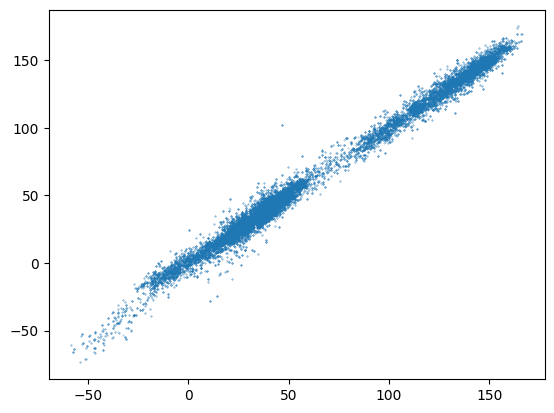

In [10]:
plt.scatter(Ypred,Ytest, s=0.1, alpha=0.5)

In [11]:
mean_squared_error(Ypred,Ytest, squared=False )

/home/yuxuzhan/miniconda3/envs/shiftML/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4.904847210004231